# Introduction


## Importance of Sentiment Analysis
"Sentiment analysis is the field of study that analyzes people's sentiments, evaluations, attitudes, and emotions from written language. Sentiment analysis systems are being applied in almost every business and social domain because opinions are central to almost all human activities and are key influencers of our behaviors. Our beliefs and perceptions of reality, and the choices we make, are largely conditioned on how others see and evaluate the world. For this reason, when we need to make a decision we often seek out the opinions of others." [1]



Source:
[1]. Bing Liu, https://www.morganclaypool.com/doi/abs/10.2200/s00416ed1v01y201204hlt016

## Main Goals
In this notebook, we will analyze sentiments from Tweets about Apple, Android, and Google products. Our goal of this project is to 

    [1] Correctly identify sentiments about certain product and 
    [2] correctly identify the product that the person is tweeting about.




# Data

The following Twitter datasets were used for this sentiment analysis:

    [1]. Given dataset: tweets
    
Additional Datasets that contain other electronic devices were obtained which might be helpful in building more reliable models with more data:

    [2]. Amazon and Best Buy electronics review dataset: https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics
    [3]. Amazon electronics review dataset: https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics
            

## Initial EDA

In [1]:
# True if ran in google colab.
GOOGLE_DRIVE = False

In [2]:
# Importing different libraries
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if GOOGLE_DRIVE:
    # Importing data from google drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Importing data from google drive
    df = pd.read_csv("drive/My Drive/dataset/twitter_sentiment/tweet_product_company.csv", 
                     encoding='unicode_escape')
    df.columns=['text', 'product', 'target']
else:
    df = pd.read_csv('datasets/tweet.csv', encoding='unicode-escape')#, encoding='unicode_escape')
    df.columns=['text', 'product', 'target']

In [4]:
df.shape

(9093, 3)

In [5]:
# Check for class imbalance
df['target'].value_counts(1)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: target, dtype: float64

> There is a great imbalance in class... Possible get around:

    [1] SMOTE - oversampling
    [2] Undersampling - since we do not have many data, we will not use undersampling technique
    [3] class_weight

In [6]:
# Drops rows with null texts.
df['text'].dropna(inplace=True, axis=0)

In [7]:
# Selecting rows where the target is not 'I can't tell'
df = df[df['target']!="I can't tell"]

In [8]:
# Dictionary with target variables to shorten their texts
target_dict = {'Negative emotion': 'Negative',
               'Positive emotion': 'Positive',
               'No emotion toward brand or product': 'Neutral'}

# Changes the target text into shorter version
df['target'] = df['target'].apply(lambda x: target_dict[x])

In [9]:
# Check for number of unique product labels
df['product'].unique()

# Product dictionary that will simplify our product list.
product_dict = {'iPad or iPhone App': 'Apple', 
                'Other Google product or service': 'Google',
                'Other Apple product or service': 'Apple'}

# Simplifies product labels
df['product'] = [product_dict[x] if x in product_dict.keys() else x for x in df['product']]

# Check for product labels
df['product'].unique()

array(['iPhone', 'Apple', 'iPad', 'Google', nan, 'Android', 'Android App'],
      dtype=object)

In [10]:
df

,text,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral
9090,"Google's Zeiger, a physician never reported po...",NaN,Neutral
9091,Some Verizon iPhone customers complained their...,NaN,Neutral


## Importing Various Libraries

In [375]:
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, recall_score
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

import re
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(0)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juhyunlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Binary Sentiment Models

## Using NLTK - TF-IDF Vectorizer

For the first round of modeling, we will solely focus on classifying either `positive` or `negative` sentiments from given tweet texts. To do so, we will follow the following steps using NLTK library:

    [1]. Tokenize words using regex
    [2]. Remove any stop words using NLTK and punctuation lists
    [3]. Vectorize words using counter and TF-IDF
    [4]. Train and Evaluate models

### Data Import

In [13]:
# Copies only positive and negative emotions from the dataset
binary_df = df[(df['target']=='Positive') | (df['target']=='Negative')].copy()

In [14]:
binary_df['target'].value_counts()

Positive    2978
Negative     570
Name: target, dtype: int64

> Observation: It's little worrisome that we are dealing with class imbalance, but we will address that issue later when making our models.

### Text Cleaning

In [15]:
# Define stopwords - excluded any negative words/abbrevations 
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
             'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
             'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
             'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
             'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does' 'did',
             'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 
             'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
             'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
             'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
             'again','further', 'then', 'once', 'here', 'there', 'when', 'where',
             'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
             'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
             'can','will','just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y'] + list(string.punctuation)

In [16]:
def process_text(tweet,
                 tokenizer='regex',
                 pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                 stopwords_list=stopwords,
                 lemmatize=True):
    """
    Removes stopwords and tokenizes an input tweet/text.
    
    Args:
        tweet (str): text that needs to be processed
        
        tokenizer (str): chooses different types of tokenizer
                         {'word', 'regex', 'tweet'}
        
        pattern (str): RegEx pattern which will be used to tokenize the input text.
                       Not needed unless tokenizer is set to 'regex'.
        
        stopwords_list (list): List of stopwords that need to be removed from tokens.
    
        lemmatize (bool): True if lemmatize (pos = 'v' by default)
    Return:
        tokens_stopped (list): List of words that are tokenized from input text
    """
    if tokenizer == 'regex':
        # Tokenizes using given regex pattern
        tokens = nltk.regexp_tokenize(tweet, pattern)
        
    elif tokenizer == 'tweet':
        tokens = TweetTokenizer().tokenize(tweet)
        
    elif tokenizer == 'word':
        tokens = word_tokenize(tweet)
    
    # Filters out all the stop words
    if stopwords_list:
        tokens = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    else:
        tokens = [token.lower() for token in tokens if len(token)>1]
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer() 
        tokens = [lemmatizer.lemmatize(x, pos='v') for x in tokens]
        
    return ' '.join(tokens)

In [17]:
# Cleans each tweet from dataset
binary_df['clean_text'] = [process_text(x, stopwords_list=None) for x in binary_df['text']]

#### Visualizing Frequent Used Words

Using WordCloud, we will visualize what words are frequenlty used in positive sentimental tweets and negative sentimental tweets about different products. We are hoping that we might see some clear difference between the vocabularies that are used in different sentiments.

In [64]:
from PIL import Image
mask = np.array(Image.open('images/tweet2.jpg'))

In [49]:
# Code inspired from https://towardsdatascience.com/create-word-cloud-into-any-shape-you-want-using-python-d0b88834bc32
def similar_color_func_blue(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None, color='blue'):
    color_dict = {'blue': 191, 'orange': 30}
    h = color_dict[color] # 0 - 360
    s = 100 # 0 - 100
    l =  np.random.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [51]:
# Code inspired from https://towardsdatascience.com/create-word-cloud-into-any-shape-you-want-using-python-d0b88834bc32
def similar_color_func_orange(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None, color='orange'):
    color_dict = {'blue': 191, 'orange': 30}
    h = color_dict[color] # 0 - 360
    s = 100 # 0 - 100
    l =  np.random.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

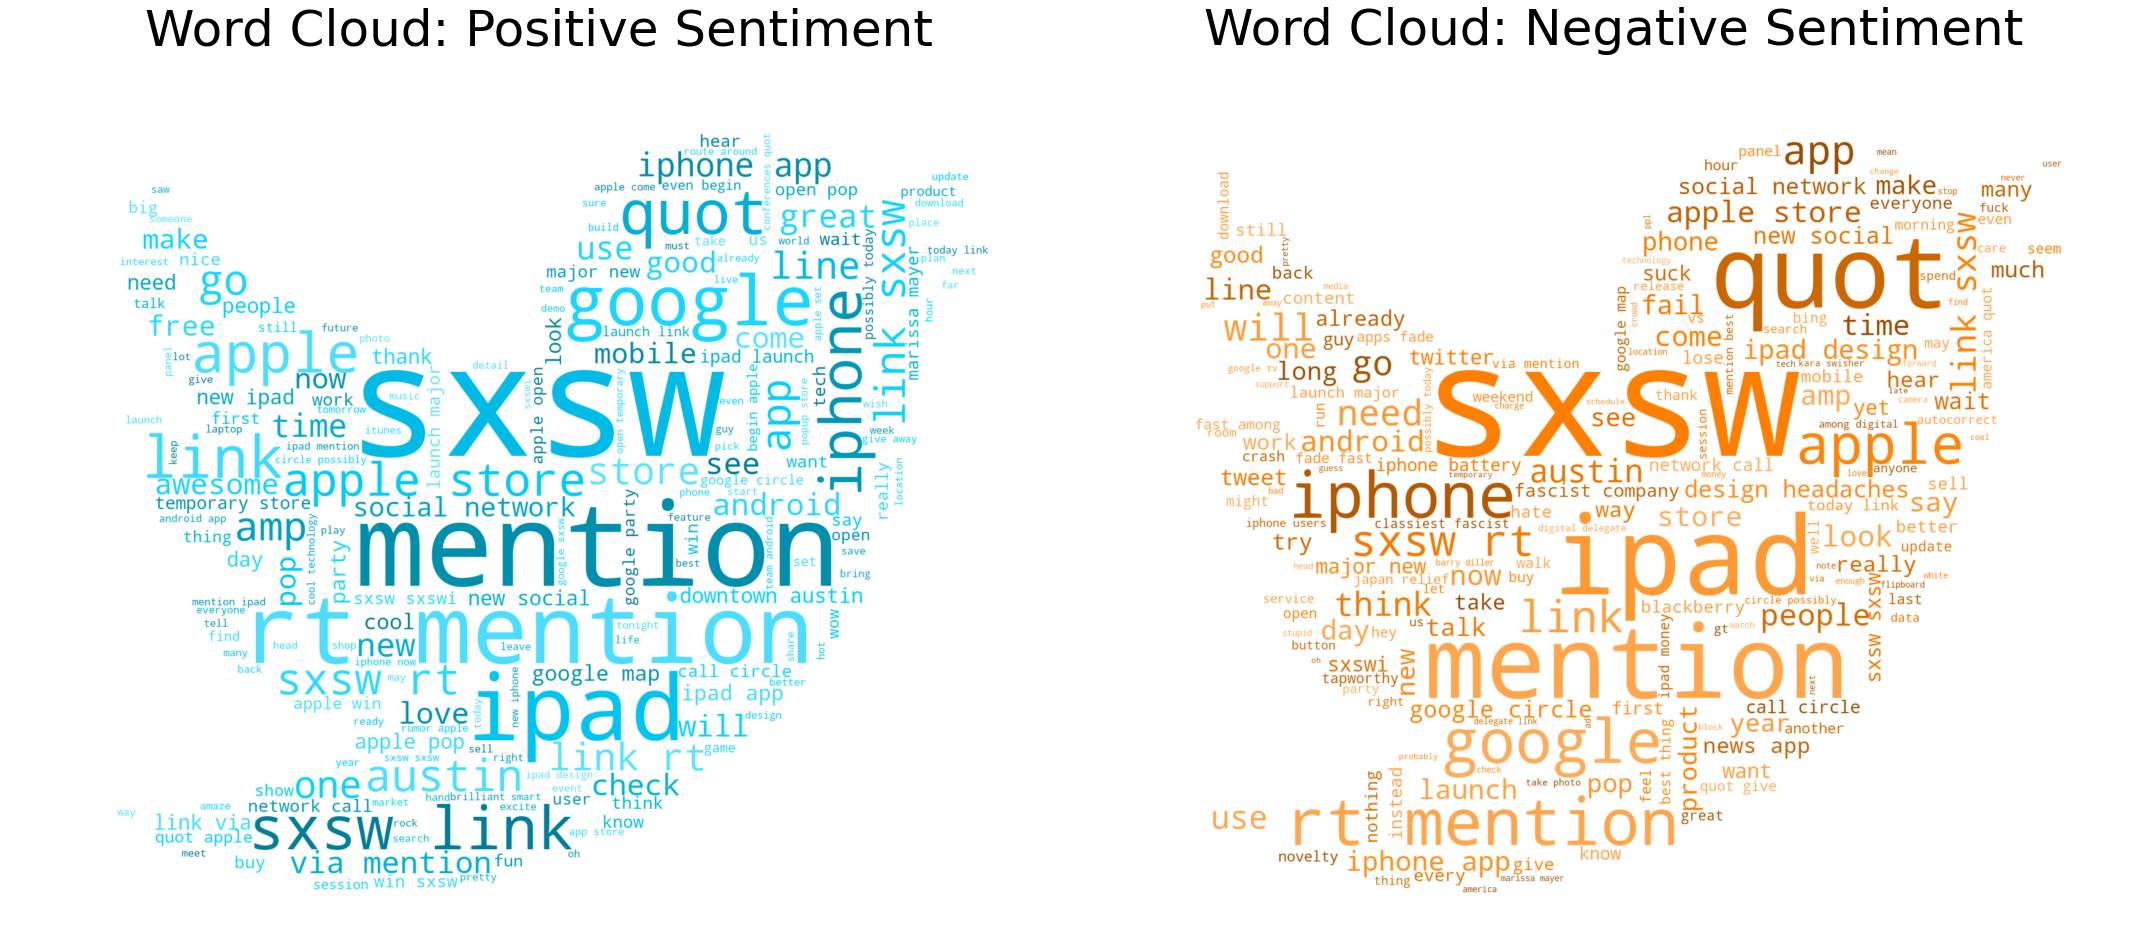

In [71]:
wordcloud = WordCloud(collocations=False)
wc_pos = WordCloud(mask=mask, background_color="white",
               max_font_size=256,
               random_state=42, width=mask.shape[1]*1.8,
               height=mask.shape[0]*1.8, color_func=similar_color_func_blue)
wc_pos.generate(','.join(binary_df[binary_df['target']=='Positive']['clean_text']))

wc_neg = WordCloud(mask=mask, background_color="white",
               max_font_size=256,
               random_state=42, width=mask.shape[1]*1.8,
               height=mask.shape[0]*1.8, color_func=similar_color_func_orange)
wc_neg.generate(','.join(binary_df[binary_df['target']=='Negative']['clean_text']))

fig, axes = plt.subplots(ncols=2, figsize=(30,15))
axes[0].axis('off')
axes[0].imshow(wc_pos, interpolation="bilinear")
axes[0].set_title('Word Cloud: Positive Sentiment', fontdict={'fontsize': 50, 'fontweight': 'medium'})

axes[1].axis('off')
axes[1].imshow(wc_neg, interpolation="bilinear")
axes[1].set_title('Word Cloud: Negative Sentiment', fontdict={'fontsize': 50, 'fontweight': 'medium'})

plt.tight_layout()

> Observation:
    We notice that the common words such as `{'mention', 'sxsw', 'link', 'quot'. ...}` are appearing in both positive and negative tweets. These words would `NOT` provide any useful information in differentiating between the sentiments.

#### Visualizing with stopwords

As you can see from the figures above, many of the words are common between negative and positive sentiment tweets including 'rt', 'sxsw', and etc. To compare the difference between the two setiments, we will remove these woreds for they do not provide any meaningful information in terms of differentiating between different sentiments.

In [63]:
stopwords += ['rt', 'sxsw', 'quot', 'ipad', 'iphone', 'mention', 'google', 'apple',
              'link', 'android', 'amp', 'app', 'store', 'austin', 'new', 'get', 'launch', 'go']

In [ ]:
# Create word cloud images for positive and negative sentiment tweets 
wc_pos = WordCloud(stopwords=stopwords, mask=mask, background_color="white",
                   max_font_size=256,
                   random_state=42, width=mask.shape[1]*1.8,
                   height=mask.shape[0]*1.8, color_func=similar_color_func_blue)
wc_pos.generate(','.join(binary_df[binary_df['target']=='Positive']['clean_text']))

wc_neg = WordCloud(stopwords=stopwords, mask=mask, background_color="white",
                   max_font_size=256,
                   random_state=42, width=mask.shape[1]*1.8,
                   height=mask.shape[0]*1.8, color_func=similar_color_func_orange)
wc_neg.generate(','.join(binary_df[binary_df['target']=='Negative']['clean_text']))

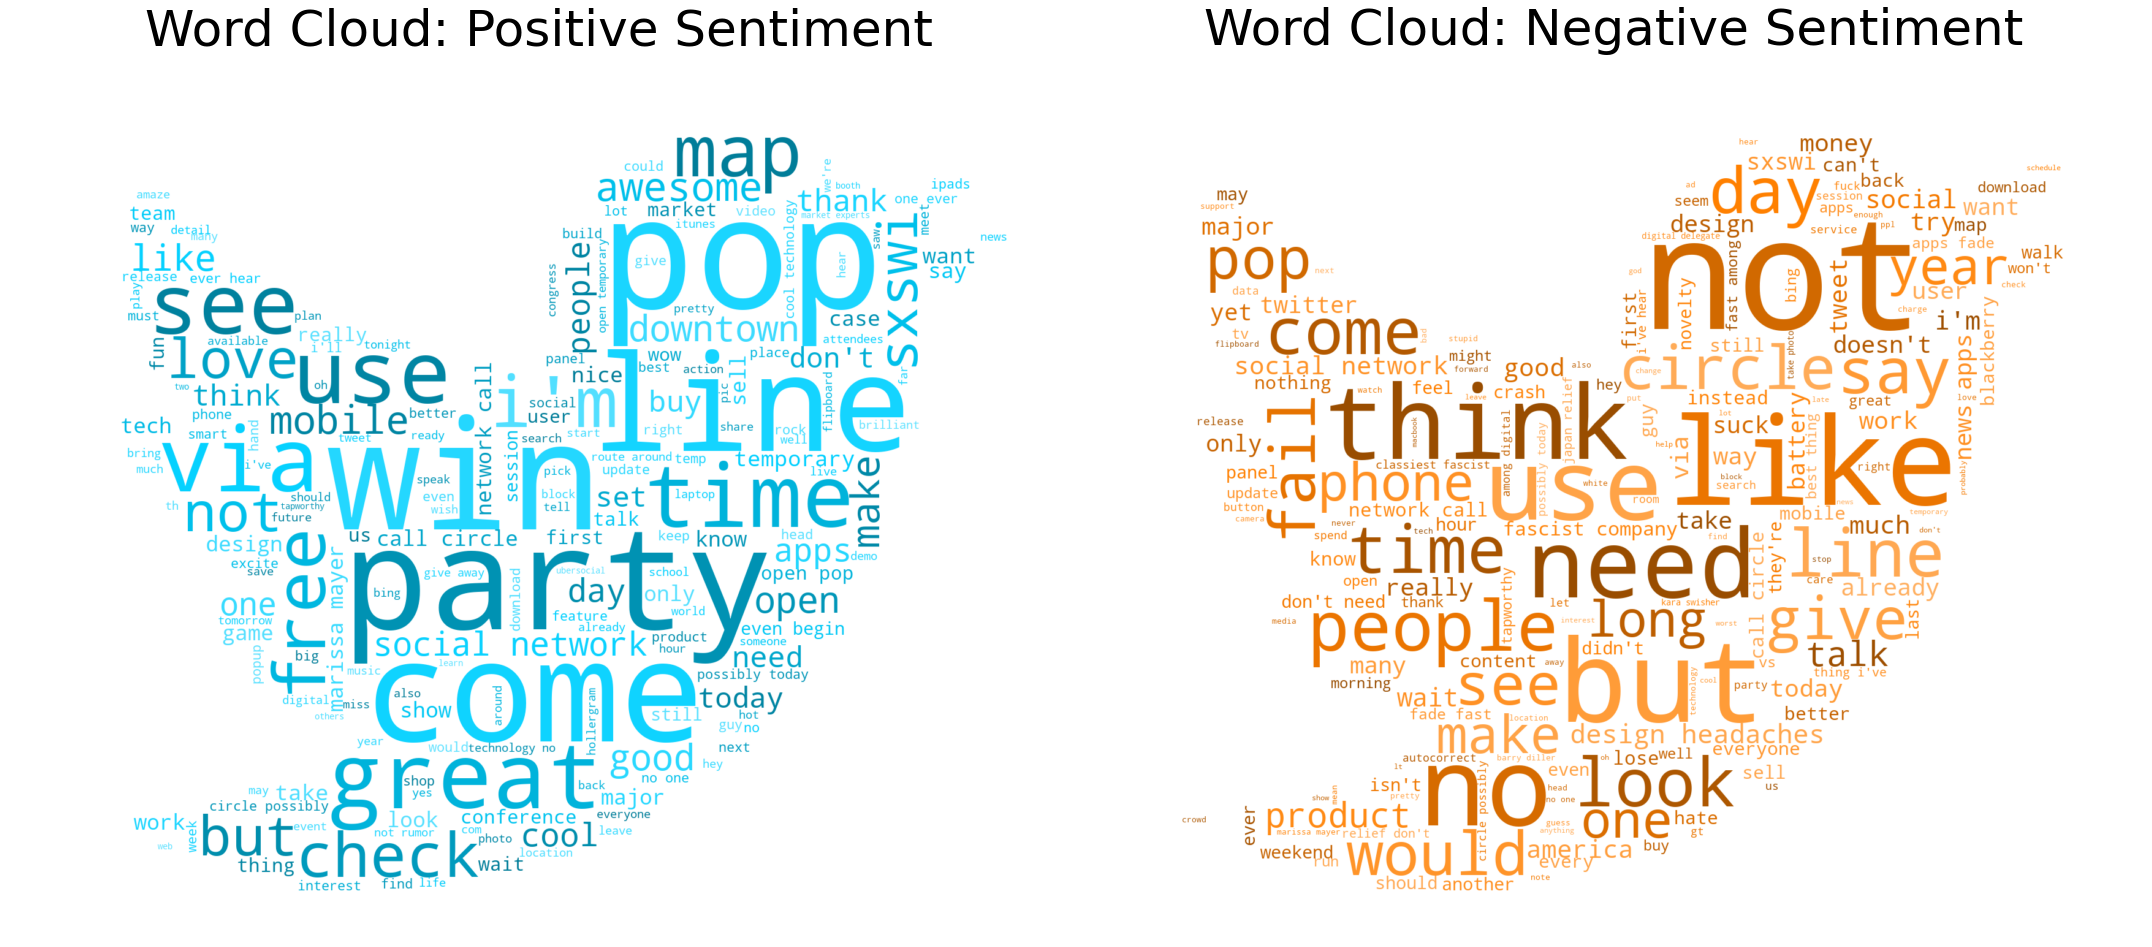

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(30,15))
axes[0].axis('off')
axes[0].imshow(wc_pos, interpolation="bilinear")
axes[0].set_title('Word Cloud: Positive Sentiment', fontdict={'fontsize': 50, 'fontweight': 'medium'})

axes[1].axis('off')
axes[1].imshow(wc_neg, interpolation="bilinear")
axes[1].set_title('Word Cloud: Negative Sentiment', fontdict={'fontsize': 50, 'fontweight': 'medium'})

plt.tight_layout()

> Observations:

Now we can see some difference in words that are used in positive and negative sentimental tweets!
-  notable positive words: `{'win', 'pop', 'great', 'like', ...}`

- Some notable negative words: `{'not', 'no', 'fail', 'need'...}`

### Preprocessing Data

In [559]:
# Tokenizes each tweet from dataset
binary_df['clean_text'] = [process_text(x, stopwords_list=stopwords) for x in binary_df['clean_text']]

In [560]:
# Splits the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(binary_df[['clean_text']],
                                                    binary_df['target'], 
                                                    random_state=42)

# Word Vectorizer - TF-IDF
vectorizer = TfidfVectorizer() #tokenizer=identity_tokenizer, lowercase=False)

X_train_vect = vectorizer.fit_transform(X_train['clean_text'])
X_test_vect = vectorizer.transform(X_test['clean_text'])

### Imbalanced Class: SMOTE

In [561]:
# Oversamples using SMOTE
X_train_vect_smote, y_train_smote = SMOTE().fit_resample(X_train_vect, y_train)

### ML Models

In [373]:
import src.useful_codes as uc

In [563]:
pd.Series(y_test).value_counts(1)

Positive    0.845547
Negative    0.154453
Name: target, dtype: float64

In [564]:
def run_model(name, params=None, data=None, report=True, classes=['Negative emotion', 'Positive emotion'], model=False):
    """
    Fits and evaluates model
    
    Args:
        name (str, obj): Name of a model OR actual model object.
                        possible names: {'RF', 'XGB', 'NB', 'SVM'}
                    
        params (dict): Dictionary of parameters for the model.
        
        **data (dataframe): X_train, X_test, y_train, y_test
        
        report (bool): True if classification report/confusion matrix is wanted.
        
        classes (list): List of target classes.
        
        model (bool): True if an actual model is added for 'name'.
    
    Returns:
        model (object): fitted model
    """
    if model:
        clf = name
    else:
        if name == 'RF':
            if params:
                clf = RandomForestClassifier(**params)
            else:
                clf = RandomForestClassifier()
        elif name == 'NB':
            if params:
                clf = MultinomialNB(**params)
            else:
                clf = MultinomialNB()
        elif name == 'XGB':
            if params:
                clf = XGBClassifier(**params)
            else:
                clf = XGBClassifier()
        elif name == 'SVM':
            if params:
                clf = LinearSVC(**params)
            else:
                clf = LinearSVC()
        elif name == 'LR':
            if params:
                clf = LogisticRegression(**params)
            else:
                clf = LogisticRegression()
    
    clf.fit(data['X_train'], data['y_train'])
    
    if report:
        uc.evaluate_clf_model(clf, data['X_train'], data['y_train'],
                              data['X_test'], data['y_test'],
                              classes=classes,
                              label=f'{name} Classifier');
    return clf

#### Random Forest

------------------------------------------------------------
[i] CLASSIFICATION REPORT RF Classifier
------------------------------------------------------------
Train Accuracy :  0.9989
Test Accuracy :  0.8895
                  precision    recall  f1-score   support

Negative emotion       0.87      0.34      0.48       137
Positive emotion       0.89      0.99      0.94       750

        accuracy                           0.89       887
       macro avg       0.88      0.66      0.71       887
    weighted avg       0.89      0.89      0.87       887

------------------------------------------------------------




RandomForestClassifier()

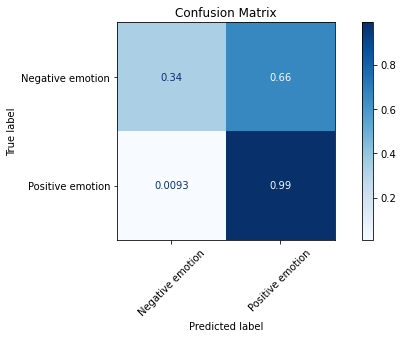

In [565]:
run_model(name='RF',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT RF Classifier
------------------------------------------------------------
Train Accuracy :  0.9993
Test Accuracy :  0.8929
                  precision    recall  f1-score   support

Negative emotion       0.83      0.39      0.53       137
Positive emotion       0.90      0.99      0.94       750

        accuracy                           0.89       887
       macro avg       0.86      0.69      0.73       887
    weighted avg       0.89      0.89      0.88       887

------------------------------------------------------------




RandomForestClassifier()

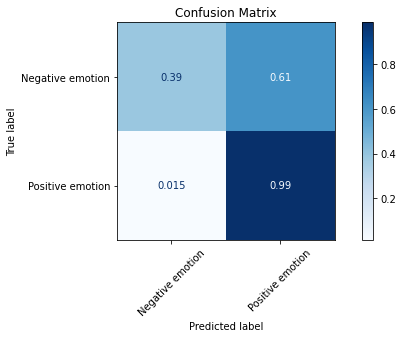

In [40]:
run_model(name='RF',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

#### Multinomial Naive Bayes

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.8643
Test Accuracy :  0.8534
                  precision    recall  f1-score   support

Negative emotion       1.00      0.05      0.10       137
Positive emotion       0.85      1.00      0.92       750

        accuracy                           0.85       887
       macro avg       0.93      0.53      0.51       887
    weighted avg       0.88      0.85      0.79       887

------------------------------------------------------------




MultinomialNB()

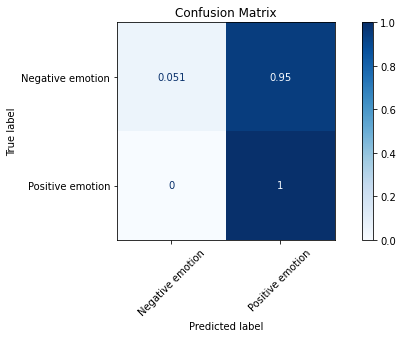

In [566]:
run_model(name='NB',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.9538
Test Accuracy :  0.7971
                  precision    recall  f1-score   support

Negative emotion       0.41      0.71      0.52       137
Positive emotion       0.94      0.81      0.87       750

        accuracy                           0.80       887
       macro avg       0.67      0.76      0.70       887
    weighted avg       0.86      0.80      0.82       887

------------------------------------------------------------




MultinomialNB()

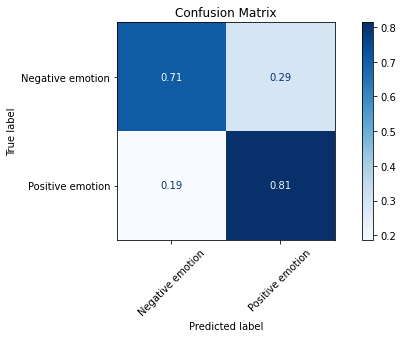

In [567]:
run_model(name='NB',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

#### XGBoost

------------------------------------------------------------
[i] CLASSIFICATION REPORT XGB Classifier
------------------------------------------------------------
Train Accuracy :  0.8681
Test Accuracy :  0.8568
                  precision    recall  f1-score   support

Negative emotion       0.71      0.12      0.21       137
Positive emotion       0.86      0.99      0.92       750

        accuracy                           0.86       887
       macro avg       0.78      0.56      0.57       887
    weighted avg       0.84      0.86      0.81       887

------------------------------------------------------------




XGBClassifier()

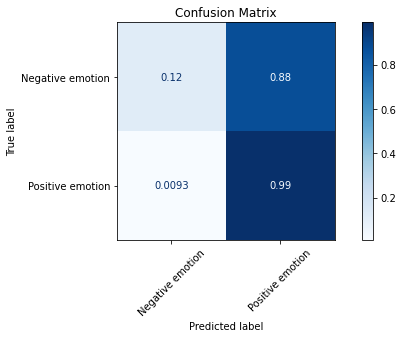

In [568]:
run_model(name='XGB',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT XGB Classifier
------------------------------------------------------------
Train Accuracy :  0.8817
Test Accuracy :  0.8546
                  precision    recall  f1-score   support

Negative emotion       0.54      0.37      0.44       137
Positive emotion       0.89      0.94      0.92       750

        accuracy                           0.85       887
       macro avg       0.72      0.66      0.68       887
    weighted avg       0.84      0.85      0.84       887

------------------------------------------------------------




XGBClassifier()

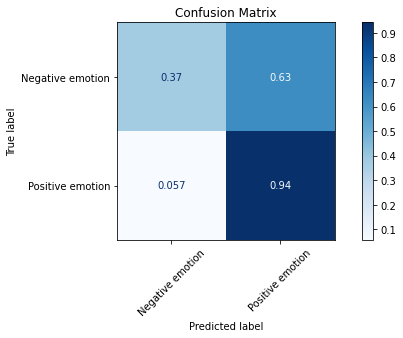

In [569]:
run_model(name='XGB',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

#### Support Vector Machine

------------------------------------------------------------
[i] CLASSIFICATION REPORT SVM Classifier
------------------------------------------------------------
Train Accuracy :  0.9929
Test Accuracy :  0.894
                  precision    recall  f1-score   support

Negative emotion       0.73      0.50      0.59       137
Positive emotion       0.91      0.97      0.94       750

        accuracy                           0.89       887
       macro avg       0.82      0.73      0.77       887
    weighted avg       0.89      0.89      0.89       887

------------------------------------------------------------




LinearSVC()

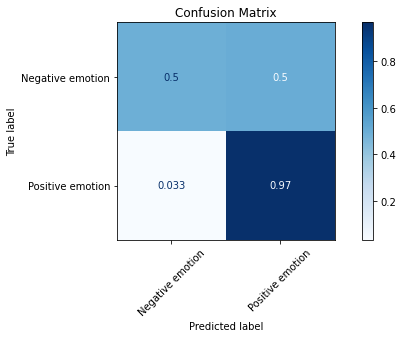

In [570]:
run_model(name='SVM',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT SVM Classifier
------------------------------------------------------------
Train Accuracy :  0.9957
Test Accuracy :  0.8703
                  precision    recall  f1-score   support

Negative emotion       0.58      0.60      0.59       137
Positive emotion       0.93      0.92      0.92       750

        accuracy                           0.87       887
       macro avg       0.75      0.76      0.76       887
    weighted avg       0.87      0.87      0.87       887

------------------------------------------------------------




LinearSVC()

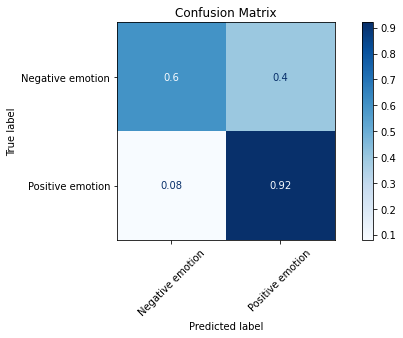

In [571]:
run_model(name='SVM',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

#### Logistic Regression

------------------------------------------------------------
[i] CLASSIFICATION REPORT LR Classifier
------------------------------------------------------------
Train Accuracy :  0.8617
Test Accuracy :  0.8534
                  precision    recall  f1-score   support

Negative emotion       0.82      0.07      0.12       137
Positive emotion       0.85      1.00      0.92       750

        accuracy                           0.85       887
       macro avg       0.84      0.53      0.52       887
    weighted avg       0.85      0.85      0.80       887

------------------------------------------------------------




LogisticRegression()

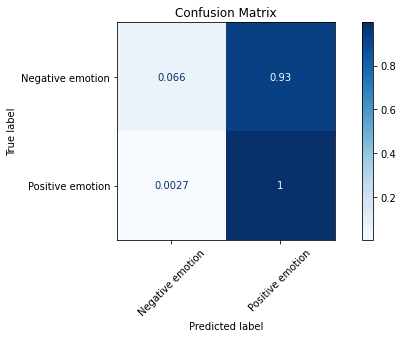

In [572]:
run_model(name='LR',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT LR Classifier
------------------------------------------------------------
Train Accuracy :  0.9708
Test Accuracy :  0.8602
                  precision    recall  f1-score   support

Negative emotion       0.54      0.61      0.57       137
Positive emotion       0.93      0.91      0.92       750

        accuracy                           0.86       887
       macro avg       0.73      0.76      0.74       887
    weighted avg       0.87      0.86      0.86       887

------------------------------------------------------------




LogisticRegression()

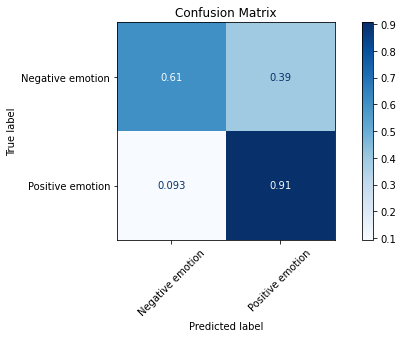

In [573]:
run_model(name='LR',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

### Model Evaluations

> Generally, models with SMOTE data did better in recalls for negative emotions compared to the normal dataset.

Since we want to ultimately add in `neutral` sentiment into our dataset, we will not tune the models just yet.

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.9538
Test Accuracy :  0.7971
                  precision    recall  f1-score   support

Negative emotion       0.41      0.71      0.52       137
Positive emotion       0.94      0.81      0.87       750

        accuracy                           0.80       887
       macro avg       0.67      0.76      0.70       887
    weighted avg       0.86      0.80      0.82       887

------------------------------------------------------------




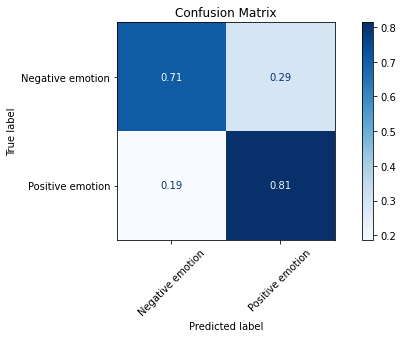

In [574]:
# Saving the best binary sentiment model using NLTK:
MultinomialNB()
binary_nb_model = run_model(name='NB',
                            data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                                  "y_train": y_train_smote, 'y_test': y_test});

In [575]:
# Saves the model
uc.save_data(binary_nb_model, 'models/binary_nb_model')

In [619]:
coef = pd.DataFrame(binary_nb_model.coef_[0], columns=['coef'])
neg_prob = pd.DataFrame(binary_nb_model.feature_log_prob_[0], columns=['neg_prob'])
pos_prob = pd.DataFrame(binary_nb_model.feature_log_prob_[1], columns=['pos_prob'])
scores = pd.concat([coef, neg_prob, pos_prob], axis=1)
scores.index = vectorizer.get_feature_names()

<AxesSubplot:title={'center':'Log-Probability for Negative Sentiments'}, xlabel='More Likely <----Log-Probability----> Less Likely', ylabel='Words'>

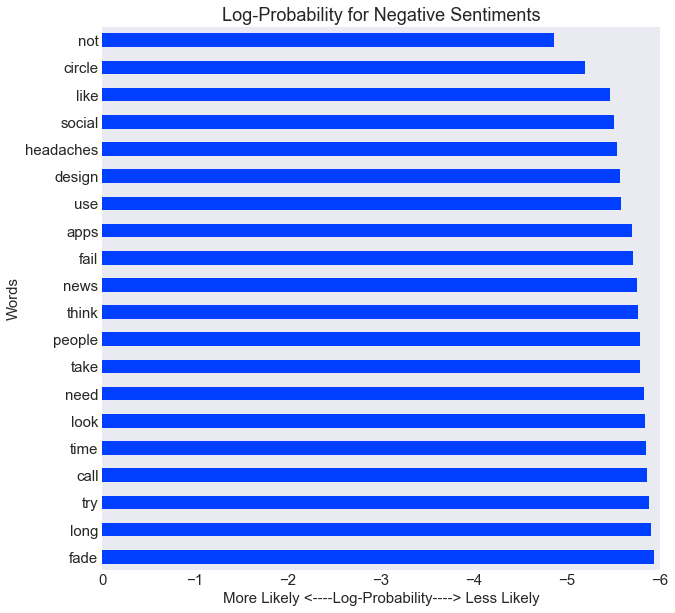

In [644]:
# sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
plt.style.use('seaborn-dark')
plt.yticks(fontsize=15)
plt.title('Log-Probability for Negative Sentiments', fontsize=18)
plt.xlabel('More Likely <----Log-Probability----> Less Likely', fontsize=15)
plt.ylabel('Words', fontsize=15)
plt.xticks(fontsize=15)
ax.set_xlim(0, -6) 
scores.sort_values(by='neg_prob').tail(20)['neg_prob'].plot(kind='barh', ax=ax)

<AxesSubplot:title={'center':'Log-Probability for Positive Sentiments'}, xlabel='More Likely <----Log-Probability----> Less Likely', ylabel='Words'>

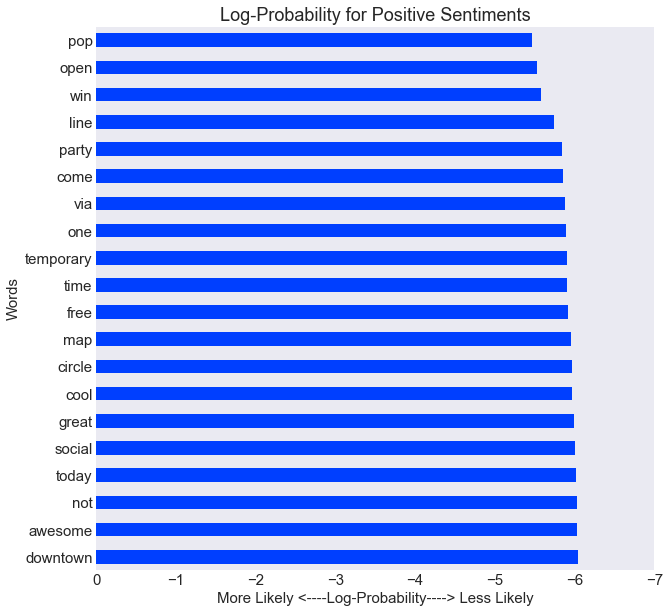

In [742]:
# sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
plt.yticks(fontsize=15)
plt.title('Log-Probability for Positive Sentiments', fontsize=18)
plt.xlabel('More Likely <----Log-Probability----> Less Likely', fontsize=15)
plt.ylabel('Words', fontsize=15)
plt.xticks(fontsize=15)
ax.set_xlim(0, -7) 
scores.sort_values(by='pos_prob').tail(20)['pos_prob'].plot(kind='barh', ax=ax)

## Using spaCy - TF-IDF Vectorizer

There are more than just NLTK library out there for us to use for NLP analysis. For example, nowadays `spacy` is a very popular NLP toolkit people use for its speed and performance.

In [97]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [773]:
# from spacy.lang.en import STOP_WORDS
# stopwords_list = list(STOP_WORDS) + list(string.punctuation)

# stopwords_list.remove(['not')

In [787]:
# Stopwords
stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
             'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
             'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
             'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
             'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does' 'did',
             'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 
             'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
             'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
             'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
             'again','further', 'then', 'once', 'here', 'there', 'when', 'where',
             'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
             'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
             'can','will','just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y'] + list(string.punctuation)

In [788]:
# Testing out Spacy's lemmatizer
def try_lemma(text):
    doc = nlp(text)
    for word in doc:
        print(word.lemma_)

In [789]:
text = "I haven't done it."
try_lemma(text)

-PRON-
have
not
do
-PRON-
.


In [77]:
def clean_text(text, stopwords=False, tweet=True):
    """
    Cleans and tokenizes tweet text data.
    Args:
        text (str): tweet text data
        
        stopwords (bool): True if stopwords needs to be removed
        
        tweet (bool): True if text data are tweets.
    
    Returns:
        tokens (array): Array of tokenized words from given text.
    """
    if tweet:
        text = re.sub(r'@\S+', '', text) # Gets rid of any mentions
        text = re.sub(r'RT\S+', '', text) # Gets rid of any retweets
        text = re.sub(r'#', '', text) # Gets rid of hashtag sign
        text = re.sub(r'https?:\/\/\S+', '', text) # Gets rid of any links
        text = re.sub(r'[0-9]+.?[0-9]+', '', text) # Gets rid of X.X where X are numbers
        text = re.sub(r'#?(sx|Sx|SX)\S+', '', text) # Gets rid common mentions
        text = re.sub(r'(&quot;|&Quot;)', '', text) # Gets rid of quotes
        text = re.sub(r'(&amp;|&Amp;)', '', text) # Gets rid of quotes
        text = re.sub(r'link', '', text) # Gets rid of quotes
    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-': # if token is not a pronoun
            temp_token = token.lemma_.lower().strip()
        else:
            temp_token = token.lower_
        tokens.append(temp_token)
    
    if stopwords:
        tokens_stopped = [token for token in tokens if token not in stopwords_list and len(token)>2]
    else:
        tokens_stopped = [token for token in tokens if len(token)>2]
    
    return tokens_stopped


In [959]:
# Copies text and target data from given dataset
binary_df2 = binary_df.reset_index()[['text', 'target']].copy()

In [960]:
# Testing out our new tokenizer
from ipywidgets import interact

@interact
def tokenize_tweet(i=(0, binary_df2.shape[0]-1)):
    target = binary_df2['target'][i]
    print('-'*30)
    print(f'Tweet #{i}\nSentiment: {target}')
    print('-'*30)
    print('\n')
    text = binary_df2['text'][i]
    
    print(text, '\n\n')
    tokens = clean_text(text, stopwords=False)
    
    print(tokens, '\n')

interactive(children=(IntSlider(value=1773, description='i', max=3547), Output()), _dom_classes=('widget-inter…

### Preprocessing

In [961]:
# Define X and y from given data.
X = binary_df2['text']
y = binary_df2['target']

In [962]:
# See class imbalane
pd.Series(y).value_counts()

Positive    2978
Negative     570
Name: target, dtype: int64

In [963]:
# Splits train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [974]:
# Instantiate TF-IDF vectorizer.
tfidf = TfidfVectorizer(tokenizer=clean_text,
                        ngram_range=(1,3),
                        max_features=1100,
                        min_df=5, max_df=0.2)

In [975]:
# Define classifier
lr = LogisticRegression(class_weight='balanced')
nb = MultinomialNB()

In [81]:
oversampler = SMOTE(random_state=42)

In [977]:
# Creates Pipeline tht works with SMOTE
from imblearn.pipeline import Pipeline
binary_clf = Pipeline([('tfidf', tfidf),
                       ('smote', SMOTE()),
                       ('clf', nb)])

### Models

In [978]:
binary_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.2, max_features=1100, min_df=5,
                                 ngram_range=(1, 3),
                                 tokenizer=<function clean_text at 0x1a3a6fd7b8>)),
                ('smote', SMOTE()), ('clf', MultinomialNB())])

In [979]:
y_pred = binary_clf.predict(X_test)

              precision    recall  f1-score   support

    Negative       0.36      0.73      0.49       115
    Positive       0.94      0.75      0.83       595

    accuracy                           0.75       710
   macro avg       0.65      0.74      0.66       710
weighted avg       0.84      0.75      0.78       710



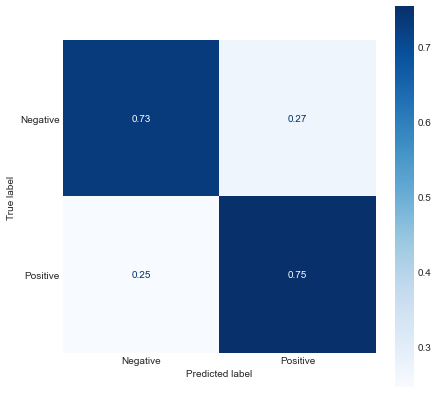

In [980]:
# ngram_range(1,3), max_feature 1100 min_df=5 max_df=0.2
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(binary_clf, X_test, y_test, normalize='true', ax=ax, cmap='Blues')

### Model Evaluation

In [971]:
# Saves the model
uc.save_data(binary_clf, 'binary_nb_spacy')

In [972]:
def get_feature_importance(pipe, classes=['Negative','Neutral', 'Positive']):
    """
    Graphs most important words used in different sentiments.
    
    Args:
        pipe (obj): pipeline object that contains classifier model (MultiNB)
        
        classes (array): list of sentiments. Must match with classes used in the model.
        
    Returns:
        fig, ax (obj): Matplotlib objects
    """
    probs = []
    for i, label in enumerate(classes):
        probs.append(pd.DataFrame(pipe.named_steps['clf'].feature_log_prob_[i], columns=[label]))

    scores = pd.concat(probs, axis=1)
    scores.index = pipe.named_steps['tfidf'].get_feature_names()
    
    for i, label in enumerate(classes):
        fig, ax = plt.subplots(figsize=(8,8))
        plt.style.use('seaborn-dark')
        plt.yticks(fontsize=15)
        plt.title(f'Log-Probability for {label} Sentiments', fontsize=18)
        plt.xlabel('More Likely <----Log-Probability----> Less Likely', fontsize=15)
        plt.ylabel('Words', fontsize=15)
        plt.xticks(fontsize=15)
        ax.set_xlim(0, -7) 
        scores.sort_values(by=label).tail(20)[label].plot(kind='barh', ax=ax)

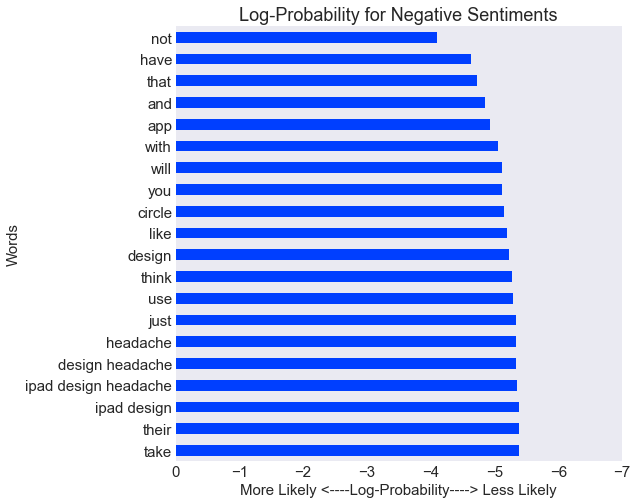

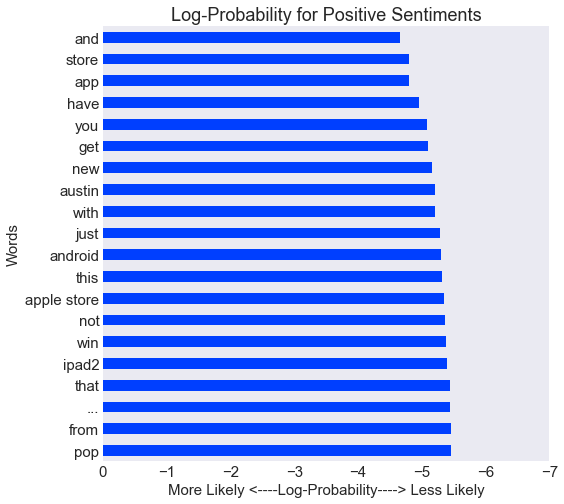

In [981]:
get_feature_importance(binary_clf, classes=['Negative', 'Positive'])

## Using spaCy - Word Embedding

In this round, we will implement word2vec word embedding for our sentiment analysis.

### Preprocessing

In [628]:
def get_vec(x):
    """
    Extracts vector out of string
    Args:
        x (str): string
    Returns:
        vec (array): word vector
    """

    doc = nlp(x)
    vec = doc.vector
    return vec


In [629]:
# Slices out rows with positive and negative sentiments
word_emb_df = df[(df['target']!="I can't tell") & (df['target']!="Neutral")][['text', 'target']]
word_emb_df['text'].dropna(inplace=True)

In [630]:
# Cleans text
word_emb_df['clean_text'] = word_emb_df['text'].apply(lambda x: ' '.join(clean_text(x, stopwords=False)))

In [631]:
# Drop rows with nulls
# word_emb_df.drop(9092, axis=0, inplace=True)
word_emb_df.dropna(inplace=True)

In [632]:
word_emb_df

,text,target,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative,have iphone after hrs tweet rise_austin dead n...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive,know about awesome ipad iphone app that you wi...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive,can not wait for ipad also they should sale th...
3,@sxsw I hope this year's festival isn't as cra...,Negative,hope this year festival not crashy this year i...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive,great stuff fri marissa mayer google tim o'rei...
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Positive,your guy just convince switch back iphone grea...
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Positive,papyrus ... sort like the ipad nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Negative,diller say google may run over the playstation...
9085,I've always used Camera+ for my iPhone b/c it ...,Positive,have always use camera+ for iphone have image ...


In [633]:
# word2vec using spacy's already trained model
word_emb_df['vec'] = word_emb_df['clean_text'].apply(lambda x: get_vec(x))

In [634]:
word_emb_df

,text,target,clean_text,vec
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative,have iphone after hrs tweet rise_austin dead n...,"[0.13263883, 0.17658408, -0.091048814, 0.03214..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive,know about awesome ipad iphone app that you wi...,"[-0.043629415, 0.2786393, -0.22279662, 0.01484..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive,can not wait for ipad also they should sale th...,"[-0.06122043, 0.1738481, -0.23934092, -0.04283..."
3,@sxsw I hope this year's festival isn't as cra...,Negative,hope this year festival not crashy this year i...,"[0.036279, 0.2006274, -0.004410401, 0.00838969..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive,great stuff fri marissa mayer google tim o'rei...,"[-0.18785122, 0.3287825, -0.019559428, 0.17529..."
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Positive,your guy just convince switch back iphone grea...,"[-0.014512899, 0.1840397, -0.2712171, 0.188799..."
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Positive,papyrus ... sort like the ipad nice lol lavelle,"[0.008511656, 0.075146675, -0.20632969, -0.143..."
9080,Diller says Google TV &quot;might be run over ...,Negative,diller say google may run over the playstation...,"[0.045776565, 0.0013999697, -0.054189622, -0.1..."
9085,I've always used Camera+ for my iPhone b/c it ...,Positive,have always use camera+ for iphone have image ...,"[0.0105489725, 0.14651729, -0.16358387, -0.117..."


In [635]:
# Defining X and y
X = word_emb_df['vec'].to_numpy()
X = X.reshape(-1, 1)

# Reset the shape properly
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

y = word_emb_df['target']

In [636]:
# Calculates class weights
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(y):
    """
    Calculates class weight of target data.
    Args:
        y (list, array): target data
    Returns:
        class_weight (list): list of class_weight values.
        class_weight_dict (dict): dictionary version of class_weight along with its class names
    """
    class_weight = list(compute_class_weight(class_weight='balanced', 
                                             classes=['Negative', 'Positive'], 
                                             y=y))
    class_weight_dict = {'Negative': class_weight[0],
#                     'Neutral': class_weight[1],
                    'Positive': class_weight[1]}
    return class_weight, class_weight_dict

In [637]:
# Calculates class_weight
class_weight, class_weight_dict = get_class_weights(y)

In [638]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

### Model

In [639]:
# Logistic classifier
clf = LogisticRegression(solver='liblinear', class_weight=class_weight_dict)

In [640]:
clf.fit(X_train, y_train)

LogisticRegression(class_weight={'Negative': 3.112280701754386,
                                 'Positive': 0.5957018132975151},
                   solver='liblinear')

### Model Evaluation

In [641]:
y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

    Negative       0.44      0.76      0.56       143
    Positive       0.95      0.82      0.88       744

    accuracy                           0.81       887
   macro avg       0.69      0.79      0.72       887
weighted avg       0.86      0.81      0.82       887



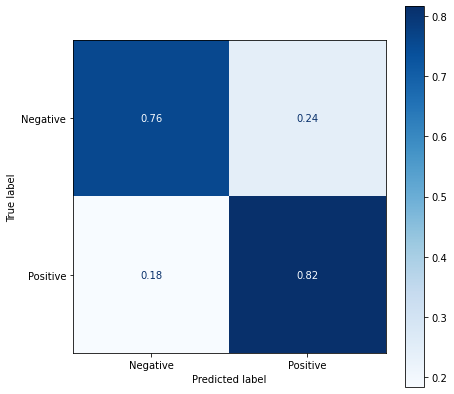

In [642]:
# Evalutating the Model
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax, cmap='Blues')

In [982]:
# Saves the model
uc.save_data(clf, 'models/binary_word_emb')

> Observations
So far, this model is the `best` in terms of both overall accuracy and negative sentiment recalls.

# Multiclass Sentiment Models

From here we will add in `neutral` sentiment. `Neutral` sentiments are very tricky to handle since it's very difficult to have true `neutral` sentiment on any subject. Nonetheless, we will make our models using the following three methods:

[1] Textblob library - very easy to use library and due to its simplicity the result may not be the best; nevertheless, a great way to start our base model for multiclass analysis

[2] spaCy TF-IDF

[3] spaCy word-embedding


## Textblob Model

In [146]:
from textblob import TextBlob

In [147]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [149]:
# Slice out rows with definable sentiments
textblob_df = df[df['target'] != "I can't tell"][['text', 'target']].copy()

textblob_df.dropna(inplace=True)

### Preprocessing

In [150]:
# cleans the data
textblob_df['clean_text'] = textblob_df['text'].apply(lambda x: ' '.join(clean_text(x, stopwords=False)))

### Calculating Polarity

In [151]:
# Get polarity and subjectivity
textblob_df['polarity'] = textblob_df['clean_text'].apply(get_polarity)
textblob_df['subjectivity'] = textblob_df['clean_text'].apply(get_subjectivity)

In [152]:
textblob_df

,text,target,clean_text,polarity,subjectivity
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative,have iphone after hrs tweet rise_austin dead n...,-0.200000,0.400000
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive,know about awesome ipad iphone app that you wi...,0.466667,0.933333
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive,can not wait for ipad also they should sale th...,-0.155556,0.288889
3,@sxsw I hope this year's festival isn't as cra...,Negative,hope this year festival not crashy this year i...,0.000000,0.000000
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive,great stuff fri marissa mayer google tim o'rei...,0.800000,0.750000
...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},Positive,ipad everywhere,0.000000,0.000000
9089,"Wave, buzz... RT @mention We interrupt your re...",Neutral,wave buzz ... interrupt your regularly schedul...,0.000000,0.088462
9090,"Google's Zeiger, a physician never reported po...",Neutral,google zeiger physician never report potential...,0.000000,1.000000
9091,Some Verizon iPhone customers complained their...,Neutral,some verizon iphone customer complain their ti...,0.068182,0.227273


### Fine-Tuning Thresholds

In [252]:
# Classifies sentiments based on lower and upper thresholds
def classify(score, lower_threshold=0, upper_threshold=0):
    if score < lower_threshold:
        return 'Negative'
    elif score > upper_threshold:
        return 'Positive'
    else:
        return 'Neutral'

In [168]:
# gets prediction based on textblob polarity value
textblob_df['pred'] = textblob_df['polarity'].apply(classify)

In [176]:
# 
from sklearn.metrics import recall_score

lower_thresholds = np.arange(-0.15, 0.1, 0.01)
upper_thresholds = np.arange(0, 0.30, 0.01)
recalls = []
for lower_threshold in lower_thresholds:
    for upper_threshold in upper_thresholds:
        textblob_df['pred'] = textblob_df['polarity'].apply(lambda x: classify(x, 
                                                                               lower_threshold=lower_threshold,
                                                                               upper_threshold=upper_threshold))
        recalls.append([lower_threshold, 
                        upper_threshold, 
                        recall_score(textblob_df['target'], textblob_df['pred'], average='macro')])

In [222]:
# creates dataframe of recalls
recall_df = pd.DataFrame(recalls, columns=['lower', 'upper', 'recall'])
recall_df.sort_values(by='recall', ascending=False)

,lower,upper,recall
399,-0.02,0.09,0.478986
369,-0.03,0.09,0.478345
429,-0.01,0.09,0.478305
400,-0.02,0.10,0.477826
406,-0.02,0.16,0.477326
...,...,...,...
689,0.07,0.29,0.398905
719,0.08,0.29,0.398612
747,0.09,0.27,0.397560
748,0.09,0.28,0.395693


In [223]:
# create rectangular matrix for heatmap
recall_heatmap = recall_df.pivot(index='lower', columns='upper', values='recall')

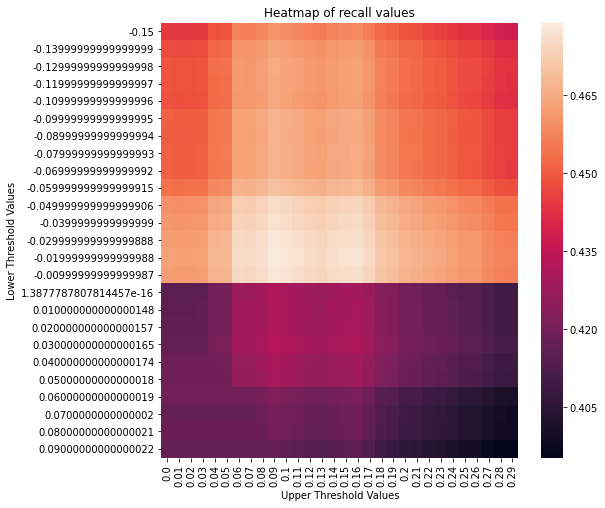

In [250]:
# Creates heatmap of recall values for different thresholds
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(recall_heatmap, ax=ax)
plt.title('Heatmap of recall values');
plt.xlabel('Upper Threshold Values');
plt.ylabel('Lower Threshold Values');
# plt.yticks(np.arange(0.1, -0.15, -0.01));

> Observation

We can conclude that

`
lower_threshold = -0.02
upper_threshold = 0.09
`

results in 'best' recall value of `0.478986`.

### Model Evaluation

In [256]:
def classify(score, lower_threshold=-0.02, upper_threshold=0.09):
    if score < lower_threshold:
        return 'Negative'
    elif score > upper_threshold:
        return 'Positive'
    else:
        return 'Neutral'

In [257]:
textblob_df['pred'] = textblob_df['polarity'].apply(classify)

In [258]:
# Final Result of the model
print(classification_report(textblob_df['target'], textblob_df['pred']))

              precision    recall  f1-score   support

    Negative       0.18      0.31      0.23       570
     Neutral       0.71      0.55      0.62      5388
    Positive       0.46      0.57      0.51      2978

    accuracy                           0.54      8936
   macro avg       0.45      0.48      0.45      8936
weighted avg       0.59      0.54      0.56      8936



> Observation
Using textblob, the model performed poorly in identifying all sentiments. 

## spaCy - TF-IDF Vectorization

### Preprocessing

In [84]:
# slice out only rows with definable sentiments
multiclass_df = df[df['target'] != "I can't tell"][['text', 'target']].copy()

In [85]:
# Drops any rows with null values
multiclass_df.dropna(inplace=True)

In [86]:
# Define X and y
X = multiclass_df['text']
y = multiclass_df['target']

In [87]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Pipeline

In [137]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(tokenizer=clean_text,
                        ngram_range=(1,3),
#                         max_features=1500,
                        min_df=10,
                        max_df=0.5)

In [138]:
# Define SMOTE
oversampler = SMOTE(random_state=42)

In [139]:
# Define classificer
nb = MultinomialNB()

In [140]:
# imblearn pipeline
multi_sentiment_clf = Pipeline([('tfidf', tfidf),
                                ('smote', oversampler),
                                ('clf', nb)])


### Model

In [141]:
# trains model
multi_sentiment_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 3),
                                 tokenizer=<function clean_text at 0x1a2a93c048>)),
                ('smote', SMOTE(random_state=42)), ('clf', MultinomialNB())])

In [142]:
y_pred = multi_sentiment_clf.predict(X_test)

              precision    recall  f1-score   support

    Negative       0.22      0.63      0.32       126
     Neutral       0.79      0.49      0.60      1094
    Positive       0.46      0.61      0.52       568

    accuracy                           0.54      1788
   macro avg       0.49      0.57      0.48      1788
weighted avg       0.65      0.54      0.56      1788



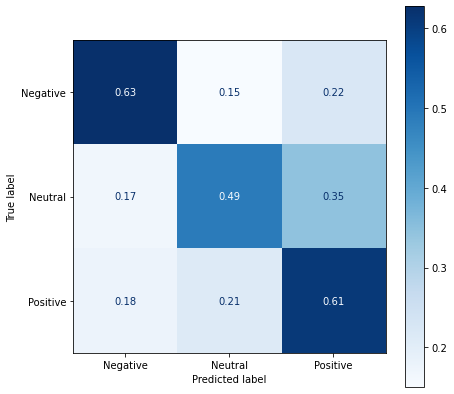

In [143]:
# Evalutating the Model
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(multi_sentiment_clf, X_test, y_test, normalize='true', ax=ax, cmap='Blues')

### Manipulating Probability Thresholds

In [646]:
threshold_df = pd.DataFrame(y_prob, columns = ['neg_prob', 'neu_prob', 'pos_prob'])
threshold_df['target'] = list(y_test)
threshold_df['predict'] = list(y_pred)
threshold_df['text'] = list(X_test)
threshold_df['token'] = list(X_test.apply(clean_text))

In [639]:
threshold_df[(threshold_df['target']=='Neutral') & (threshold_df['predict']!='Neutral')]

,neg_prob,neu_prob,pos_prob,target,predict,text,token
0,0.493266,0.380127,0.126607,Neutral,Negative,ÛÏ@mention Google doesn't place any value on ...,"[ûï, place, val]"
1,0.195697,0.330160,0.474143,Neutral,Positive,"RT @mention One minute ago, the guy I spoke ou...","[min, apple, hand, ipad, wai, ...]"
8,0.400544,0.331272,0.268185,Neutral,Negative,I had to pull out my iPhone and look busy to f...,"[iph, fit, badge, line]"
14,0.082550,0.102345,0.815104,Neutral,Positive,#SXSW #apple store just sold their last #ipad,"[apple, ipad]"
15,0.504206,0.359107,0.136688,Neutral,Negative,RT @mention Google (tries again) to launch a n...,"[new, circle]"
...,...,...,...,...,...,...,...
1771,0.082944,0.178916,0.738140,Neutral,Positive,"If you got a view master last night, we can't ...","[view, nigh, wait, win, ipad]"
1773,0.129863,0.245512,0.624625,Neutral,Positive,#SXSW Apple Pop Up Store still has iPads in st...,"[apple, ipad, wai, line, apple, ipad2û]"
1777,0.127082,0.334065,0.538853,Neutral,Positive,Grab the latest @mention before #SXSW! {link},"[grab, bef]"
1783,0.038999,0.161779,0.799222,Neutral,Positive,Thanks to everyone for making it a great day i...,"[thank, great, day]"


In [644]:
threshold_df['text'].iloc[15]

'RT @mention Google (tries again) to launch a new social network called Circles: {link} #sxsw'

In [667]:
threshold = 0.5

In [653]:
threshold_df['test'] = (abs(threshold_df['neg_prob']-threshold_df['neu_prob'])<threshold) | \
                       (abs(threshold_df['pos_prob']-threshold_df['neu_prob'])<threshold) 

In [658]:
threshold_df['new_predict'] = ['Neutral' if x else y for x, y in zip(threshold_df['test'], threshold_df['predict'])] 

In [660]:
accuracy_score(threshold_df['target'], threshold_df['predict'])

0.6403803131991052

In [661]:
from sklearn.metrics import confusion_matrix

In [664]:
confusion_matrix(threshold_df['target'], threshold_df['predict'], normalize='true')

array([[0.53174603, 0.23809524, 0.23015873],
       [0.08683729, 0.66270567, 0.25045704],
       [0.07394366, 0.30457746, 0.62147887]])

In [669]:
confusion_matrix(threshold_df['target'], threshold_df['new_predict'], normalize='true')[1][1]

0.9058500914076782

In [678]:
neg_recalls = []
neu_recalls = []
pos_recalls = []
thresholds = np.linspace(0,0.1, 9)
thresholds

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   ])

In [679]:
for threshold in thresholds:
    threshold_df['test'] = (abs(threshold_df['neg_prob']-threshold_df['neu_prob'])<threshold) | \
                       (abs(threshold_df['pos_prob']-threshold_df['neu_prob'])<threshold) 
    threshold_df['new_predict'] = ['Neutral' if x else y for x, y in zip(threshold_df['test'], threshold_df['predict'])] 
    conf = confusion_matrix(threshold_df['target'], threshold_df['new_predict'], normalize='true')
    neg_recalls.append(conf[0][0])
    neu_recalls.append(conf[1][1])
    pos_recalls.append(conf[2][2])

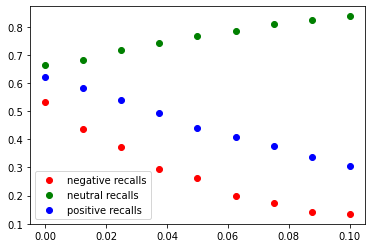

In [684]:
plt.scatter(x=thresholds, y=neg_recalls, linestyle='-', label='negative recalls', color='r')
plt.scatter(x=thresholds, y=neu_recalls, linestyle='-', label='neutral recalls', color='g')
plt.scatter(x=thresholds, y=pos_recalls, linestyle='-', label='positive recalls', color='b')
plt.legend()

## spaCy - Word Embedding

In [259]:
def get_vec(x):
    """
    Extracts vector out of string
    Args:
        x (str): string
    Returns:
        vec (array): word vector
    """

    doc = nlp(x)
    vec = doc.vector
    return vec


In [260]:
# Slices out rows with positive and negative sentiments
word_emb_df = df[(df['target']!="I can't tell")][['text', 'target']]
word_emb_df['text'].dropna(inplace=True)

In [261]:
# Cleans text
word_emb_df['clean_text'] = word_emb_df['text'].apply(lambda x: ' '.join(clean_text(x, stopwords=False)))

In [262]:
# Drop rows with nulls
# word_emb_df.drop(9092, axis=0, inplace=True)
word_emb_df.dropna(inplace=True)

In [263]:
word_emb_df

,text,target,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative,have iphone after hrs tweet rise_austin dead n...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive,know about awesome ipad iphone app that you wi...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive,can not wait for ipad also they should sale th...
3,@sxsw I hope this year's festival isn't as cra...,Negative,hope this year festival not crashy this year i...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive,great stuff fri marissa mayer google tim o'rei...
...,...,...,...
9088,Ipad everywhere. #SXSW {link},Positive,ipad everywhere
9089,"Wave, buzz... RT @mention We interrupt your re...",Neutral,wave buzz ... interrupt your regularly schedul...
9090,"Google's Zeiger, a physician never reported po...",Neutral,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,Neutral,some verizon iphone customer complain their ti...


In [264]:
# word2vec using spacy's already trained model
word_emb_df['vec'] = word_emb_df['clean_text'].apply(lambda x: get_vec(x))

In [265]:
word_emb_df

,text,target,clean_text,vec
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative,have iphone after hrs tweet rise_austin dead n...,"[0.13263883, 0.17658408, -0.091048814, 0.03214..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive,know about awesome ipad iphone app that you wi...,"[-0.043629415, 0.2786393, -0.22279662, 0.01484..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive,can not wait for ipad also they should sale th...,"[-0.06122043, 0.1738481, -0.23934092, -0.04283..."
3,@sxsw I hope this year's festival isn't as cra...,Negative,hope this year festival not crashy this year i...,"[0.036279, 0.2006274, -0.004410401, 0.00838969..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive,great stuff fri marissa mayer google tim o'rei...,"[-0.18785122, 0.3287825, -0.019559428, 0.17529..."
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},Positive,ipad everywhere,"[0.027625, 0.026979998, -0.18189, -0.036190003..."
9089,"Wave, buzz... RT @mention We interrupt your re...",Neutral,wave buzz ... interrupt your regularly schedul...,"[-0.101777926, 0.15536918, -0.058731355, 0.191..."
9090,"Google's Zeiger, a physician never reported po...",Neutral,google zeiger physician never report potential...,"[-0.07161147, 0.03903446, -0.17599213, 0.05086..."
9091,Some Verizon iPhone customers complained their...,Neutral,some verizon iphone customer complain their ti...,"[0.065544054, 0.18037274, -0.07992869, -0.0851..."


In [266]:
# Defining X and y
X = word_emb_df['vec'].to_numpy()
X = X.reshape(-1, 1)

# Reset the shape properly
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

y = word_emb_df['target']

In [267]:
# Calculates class weights
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(y):
    """
    Calculates class weight of target data.
    Args:
        y (list, array): target data
    Returns:
        class_weight (list): list of class_weight values.
        class_weight_dict (dict): dictionary version of class_weight along with its class names
    """
    class_weight = list(compute_class_weight(class_weight='balanced', 
                                             classes=['Negative', 'Neutral', 'Positive'], 
                                             y=y))
    class_weight_dict = {'Negative': class_weight[0],
                         'Neutral': class_weight[1],
                         'Positive': class_weight[2]}
    return class_weight, class_weight_dict

In [268]:
# Calculates class_weight
class_weight, class_weight_dict = get_class_weights(y)

In [269]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

### Model

In [460]:
# Logistic classifier
multiclass_clf = LogisticRegression(solver='newton-cg', 
                                    class_weight=class_weight_dict,
                                    C=100)

In [461]:
multiclass_clf.fit(X_train, y_train)

LogisticRegression(C=100,
                   class_weight={'Negative': 5.2257309941520464,
                                 'Neutral': 0.5528334570650829,
                                 'Positive': 1.0002238638907543},
                   solver='newton-cg')

### Model Evaluation

              precision    recall  f1-score   support

    Negative       0.25      0.71      0.36       143
     Neutral       0.78      0.59      0.67      1347
    Positive       0.54      0.59      0.57       744

    accuracy                           0.60      2234
   macro avg       0.52      0.63      0.53      2234
weighted avg       0.67      0.60      0.61      2234



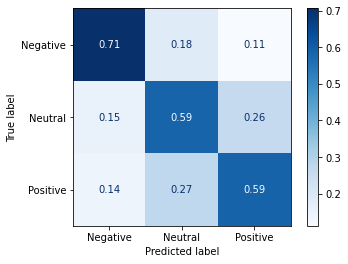

In [462]:
y_pred = multiclass_clf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(multiclass_clf, X_test, y_test, normalize='true', cmap='Blues')

In [463]:
# Saves the model
uc.save_data(multiclass_clf, 'models/multiclass_word_emb')

> Observation
The model is not doing so hot, however it has made a huge improvement from both `textblob model` and `spaCy TF-IDF model`.

spaCy's word embedding model has the highest negative sentiment recall (0.71).

# Using Additional Dataset

We have seen that we have a couple of problems with the given dataset:
    
    [1]. Imbalance
    
            No emotion toward brand or product    0.592654
            Positive emotion                      0.327505
            Negative emotion                      0.062686
            I can't tell                          0.017156
            
    [2]. Relatively small data size: 9093 rows
    * The total number of rows may seem like it's a reasonable number, but considering its class imbalance, the number is quite small.

So, to get around this, what we will do is that we will implement a dataset that contains electronic reviews from Amazon and BestBuy.

*Reminder: This dataset can be obtained at https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics

In [464]:
# Import the new dataset
amazon = pd.read_csv('datasets/amazon_review.csv')
elec = pd.read_csv('datasets/electronics_review.csv')

## Making a model from additional dataset

### Preprocessing

In [465]:
# Extact data that we want from dataframe
amazon = amazon[['reviews.text', 'reviews.rating']]
amazon.columns = ['text', 'rating']

elec = elec[['reviews.text', 'reviews.rating']]
elec.columns = ['text', 'rating']

In [466]:
# Drops any Null rows
amazon.dropna(inplace=True)
elec.dropna(inplace=True)

In [467]:
amazon['rating'].value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: rating, dtype: int64

In [468]:
elec['rating'].value_counts()

5.0    4490
4.0    1660
3.0     440
1.0     318
2.0     222
Name: rating, dtype: int64

In [469]:
# combine the two dataframes into one
review_df = pd.concat([amazon, elec])

In [470]:
# Dictionary to change numerical rating into sentiment rating
score_dict = {5.0:'Positive', 4.0:'Positive', 
              3.0:'Neutral', 
              2.0:'Negative', 1.0:'Negative'}

In [471]:
# Converts numerical rating to categorical
review_df['target'] = review_df['rating'].apply(lambda x: score_dict[x])

<AxesSubplot:>

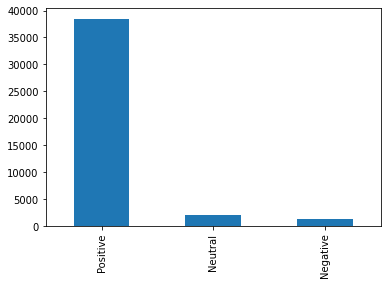

In [472]:
# Visualize distribution of different sentiments
review_df['target'].value_counts().plot.bar()

In [473]:
review_df['target'].value_counts()

Positive    38465
Neutral      1939
Negative     1352
Name: target, dtype: int64

> Still imbalance in class; however, the number of negative and neutral sentiment reviews are more than what we have in the actual dataset.

In [474]:
review_df

,text,rating,target
0,This product so far has not disappointed. My c...,5.0,Positive
1,great for beginner or experienced person. Boug...,5.0,Positive
2,Inexpensive tablet for him to use and learn on...,5.0,Positive
3,I've had my Fire HD 8 two weeks now and I love...,4.0,Positive
4,I bought this for my grand daughter when she c...,5.0,Positive
...,...,...,...
7294,This remote was a decent replacement for my lo...,4.0,Positive
7295,This looks good on my celling. Flushes very we...,4.0,Positive
7296,"Great Plate for projector mount, very easy to ...",4.0,Positive
7297,This mount worked very well for me when I used...,5.0,Positive


### Undersampling

In [498]:
X = review_df['text']
y = review_df['target']

In [499]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [500]:
randus = RandomUnderSampler(random_state=42)

### Models

In [501]:
tfidf = TfidfVectorizer(tokenizer=clean_text, 
                        ngram_range=(1,3), 
                        max_features=1000)

In [502]:
# Creates Pipeline
nb = MultinomialNB()
review_clf = Pipeline([('tfidf', tfidf),
                       ('undersampling', randus),
                       ('clf', nb)])

In [503]:
review_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 3),
                                 tokenizer=<function clean_text at 0x1a2a93c048>)),
                ('undersampling', RandomUnderSampler(random_state=42)),
                ('clf', MultinomialNB())])

In [504]:
y_pred = review_clf.predict(X_test)

### Model Evaluation

              precision    recall  f1-score   support

    Negative       0.15      0.70      0.25       267
     Neutral       0.11      0.50      0.18       374
    Positive       0.99      0.68      0.81      7711

    accuracy                           0.67      8352
   macro avg       0.41      0.63      0.41      8352
weighted avg       0.92      0.67      0.76      8352



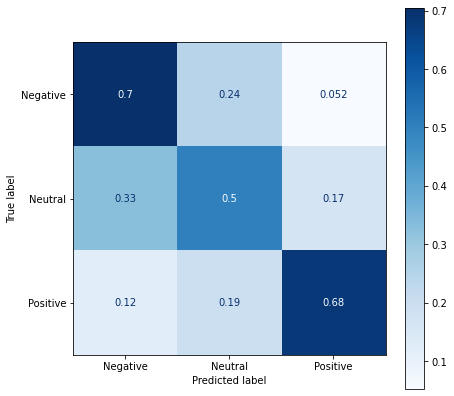

In [506]:
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(review_clf, X_test, y_test, normalize='true', ax=ax, cmap='Blues')

In [274]:
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(review_clf, X_test['text'], y_test, normalize='true', ax=ax, cmap='Blues')

              precision    recall  f1-score   support

    Negative       0.18      0.69      0.28       267
     Neutral       0.11      0.45      0.18       374
    Positive       0.98      0.74      0.84      7711

    accuracy                           0.72      8352
   macro avg       0.42      0.63      0.43      8352
weighted avg       0.92      0.72      0.79      8352



> Observation
This model works pretty well within its dataset (amazon and bestbuy reviews). Let's see how it does with our twitter dataset!

#### Testing out the original test set

In [508]:
# slice out only rows with definable sentiments
review_test_df = df[df['target'] != "I can't tell"][['text', 'target']].copy()
review_test_df.dropna(inplace=True)
X = review_test_df['text']
y = review_test_df['target']

In [509]:
y_pred = review_clf.predict(X)

              precision    recall  f1-score   support

    Negative       0.08      0.50      0.14       570
     Neutral       0.59      0.50      0.54      5388
    Positive       0.37      0.10      0.15      2978

    accuracy                           0.37      8936
   macro avg       0.35      0.37      0.28      8936
weighted avg       0.49      0.37      0.39      8936



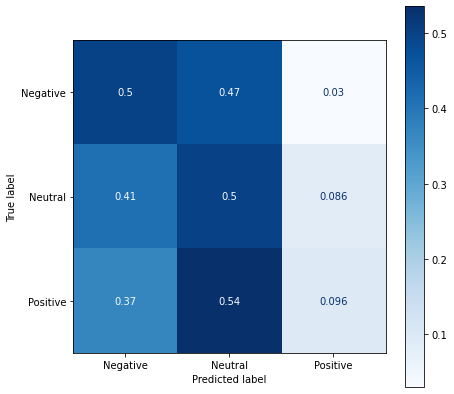

In [510]:
print(classification_report(y, y_pred))

fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(review_clf, X, y, normalize='true', ax=ax, cmap='Blues')

> Observation

Even though we thought having additional reviews of similar product types (electronics) would help with making a good model, it did not work.

## Mixing the data

This time we will first train test split our original data and we will mix train data with the new additional data from amazon and best buy to train our model.

### Original Data

In [511]:
# slice out only rows with definable sentiments
review_test_df = df[df['target'] != "I can't tell"][['text', 'target']].copy()
review_test_df.dropna(inplace=True)
X = review_test_df['text']
y = review_test_df['target']

In [512]:
X_train_add, X_test, y_train_add, y_test = train_test_split(X, y, random_state=42)

In [565]:
print(X_test.shape, y_test.shape)

(2234,) (2234,)


### Mixing the data

In [534]:
review_df

,text,rating,target
0,This product so far has not disappointed. My c...,5.0,Positive
1,great for beginner or experienced person. Boug...,5.0,Positive
2,Inexpensive tablet for him to use and learn on...,5.0,Positive
3,I've had my Fire HD 8 two weeks now and I love...,4.0,Positive
4,I bought this for my grand daughter when she c...,5.0,Positive
...,...,...,...
7294,This remote was a decent replacement for my lo...,4.0,Positive
7295,This looks good on my celling. Flushes very we...,4.0,Positive
7296,"Great Plate for projector mount, very easy to ...",4.0,Positive
7297,This mount worked very well for me when I used...,5.0,Positive


In [536]:
# Define X and y from additional datasets
X = review_df[['text']]
y = review_df['target']

In [537]:
X_under, y_under = randus.fit_sample(X, y)

In [539]:
pd.Series(y_under).value_counts()

Positive    1352
Neutral     1352
Negative    1352
dtype: int64

In [547]:
y_under

array(['Negative', 'Negative', 'Negative', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [548]:
# Combines the original train and additional datasets
X = pd.concat([pd.Series(X_under.ravel()), X_train_add], axis=0)
y = pd.concat([pd.Series(y_under), y_train_add], axis=0)

In [582]:
X_train_word_emb = pd.DataFrame(X, columns=['text'])
X_train_word_emb['target'] = y
X_train_word_emb['clean_text'] = X_train_word_emb['text'].apply(lambda x: ' '.join(clean_text(x, stopwords=False)))

In [587]:
# word2vec using spacy's already trained model
X_train_word_emb['vec'] = X_train_word_emb['clean_text'].apply(lambda x: get_vec(x))

In [588]:
X_train_word_emb.dropna(inplace=True)

In [589]:
X_train_word_emb

,text,target,clean_text,vec
0,Didn't have some of the features I was looking...,Negative,not have some the feature look for return the ...,"[0.046322465, 0.074405596, -0.24040915, -0.042..."
1,i Bought this around black friday for $60 hopi...,Negative,buy this around black friday for hope would aw...,"[-0.031926136, 0.10895532, -0.18640584, -0.057..."
2,I bought this tablet for my 4 year old daughte...,Negative,buy this tablet for year old daughter too many...,"[-0.14150625, 0.12942763, -0.14784178, -0.0511..."
3,Didn't want to go to the sites amazon wanted m...,Negative,not want the site amazon want,"[-0.080505334, 0.14865167, -0.30081502, 0.0645..."
4,Not a good product short battery life i can on...,Negative,not good product short battery life can only u...,"[-0.108395725, 0.29887816, -0.1184, 0.00197591..."
...,...,...,...,...
5837,RT @mention Google Latitude Check-ins Follow F...,Neutral,google latitude check follow foursquare reward...,"[-0.045378882, 0.0991185, -0.13062267, 0.11213..."
5285,RT @mention #sxsw bound! Keep an eye out I may...,Positive,bind keep eye out may give away iphone case at...,"[0.03016857, 0.089535326, -0.15498658, 0.00983..."
5488,RT @mention Are you at #sxsw? Check out #Tokii...,Neutral,you check out tokii the the maple leaf digital...,"[0.10161455, 0.042305365, -0.10891082, -0.0774..."
873,"Come find me at the @mention booth, I have 2 @...",Neutral,come find the booth have ipad case leave and h...,"[-0.03609631, 0.1949744, -0.18391, 0.058419153..."


In [590]:
# Defining X and y
X = X_train_word_emb['vec'].to_numpy()
X = X.reshape(-1, 1)

# Reset the shape properly
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

y = X_train_word_emb['target']

In [593]:
# word2vec X_test
X_test_word_emb = pd.DataFrame(X_test, columns=['text'])
X_test_word_emb['clean_text'] = X_test_word_emb['text'].apply(lambda x: ' '.join(clean_text(x, stopwords=False)))

In [594]:
# word2vec using spacy's already trained model
X_test_word_emb['vec'] = X_test_word_emb['clean_text'].apply(lambda x: get_vec(x))

In [595]:
# Defining X and y
X_test = X_test_word_emb['vec'].to_numpy()
X_test = X_test.reshape(-1, 1)

# Reset the shape properly
X_test = np.concatenate(np.concatenate(X_test, axis=0), axis=0).reshape(-1, 300)

### Model

In [624]:
# Logistic classifier
multiclass_mixed_clf = LogisticRegression(solver='newton-cg', 
                                          class_weight=class_weight_dict,
                                          C=10)

In [625]:
multiclass_mixed_clf.fit(X, y)

LogisticRegression(C=10,
                   class_weight={'Negative': 5.2257309941520464,
                                 'Neutral': 0.5528334570650829,
                                 'Positive': 1.0002238638907543},
                   solver='newton-cg')

### Model Evaluation

              precision    recall  f1-score   support

    Negative       0.22      0.72      0.34       159
     Neutral       0.77      0.54      0.63      1356
    Positive       0.51      0.55      0.53       719

    accuracy                           0.55      2234
   macro avg       0.50      0.60      0.50      2234
weighted avg       0.65      0.55      0.58      2234



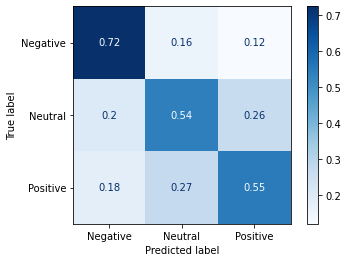

In [626]:
y_pred = multiclass_mixed_clf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(multiclass_mixed_clf, X_test, y_test, normalize='true', cmap='Blues')

In [627]:
# Saves the model
uc.save_data(multiclass_mixed_clf, 'models/multiclass_mixed_word_emb')

# Identifying Product Names

In [643]:
import spacy
from spacy import displacy

In [644]:
nlp = spacy.load('en_core_web_sm')

In [645]:
product_df = df.dropna().copy()

In [646]:
product_df

,text,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive
9080,Diller says Google TV &quot;might be run over ...,Google,Negative
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,Positive


In [647]:
from spacy.lang.en import STOP_WORDS
stopwords_list = list(STOP_WORDS) + list(string.punctuation)# + ['app']

In [648]:
def clean_text(text):
    text = re.sub(r'@\S+', '', text) # Gets rid of any mentions
    text = re.sub(r'RT\S+', '', text) # Gets rid of any retweets
    text = re.sub(r'#', '', text) # Gets rid of hashtag sign
    text = re.sub(r'https?:\/\/\S+', '', text) # Gets rid of any links
    text = re.sub(r'[0-9]+.?[0-9]+', '', text) # Gets rid of X.X where X are numbers
    text = re.sub(r'#?[sSxX]\S+', '', text) # Gets rid of X.X where X are numbers

    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-': # if token is not a pronoun
            temp_token = token.lemma_.lower().strip()
        else:
            temp_token = token.lower_
        tokens.append(temp_token)
    
    tokens_stopped = [token for token in tokens if token not in stopwords_list and len(token)>2]
    
    return tokens_stopped


In [649]:
sample_text = product_df['text'].iloc[0]
print(sample_text)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


In [650]:
X = product_df['text']
y = product_df['product']

In [651]:
pd.Series(y).value_counts(1)

Apple          0.354662
iPad           0.287020
Google         0.219683
iPhone         0.090189
Android App    0.024680
Android        0.023766
Name: product, dtype: float64

In [652]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [653]:
tfidf = TfidfVectorizer(tokenizer=clean_text)

In [654]:
X_train

3485    #sxsw fashion essential #2:  iPad plus 2 mobil...
3633    @mention if you have an iPhone get the #SXSW G...
478     Before It Even Begins, Apple WinsåÊSXSW {link}...
8855    If there was a popup store in Austin that sold...
1528    @mention (CEO Gowalla) tells his journey of Bl...
                              ...                        
2851    #SXSW I need the best android dev here.  Html5...
2946    Ha! RT @mention Google guy at #sxsw talk is ex...
3389    Lunch with @mention at #CNNGrill. View from th...
2245    Google web fonts...pretty... #sxsw #tradeshow ...
8794    Photo: Saving up for an iPad 2 #SXSW style! #H...
Name: text, Length: 2625, dtype: object

In [655]:
lr = LogisticRegression(class_weight='balanced')
svc = LinearSVC()

In [656]:
clf = Pipeline([('tfidf', tfidf),
                ('clf', lr)])

In [657]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function clean_text at 0x1ab5d8cea0>)),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [658]:
y_pred = clf.predict(X_test)

In [659]:
accuracy_score(y_test, y_pred)

0.9056316590563166

              precision    recall  f1-score   support

     Android       0.73      0.73      0.73        15
 Android App       0.68      0.81      0.74        16
       Apple       0.93      0.84      0.89       238
      Google       0.99      0.99      0.99       141
        iPad       0.92      0.94      0.93       186
      iPhone       0.73      0.92      0.81        61

    accuracy                           0.91       657
   macro avg       0.83      0.87      0.85       657
weighted avg       0.91      0.91      0.91       657



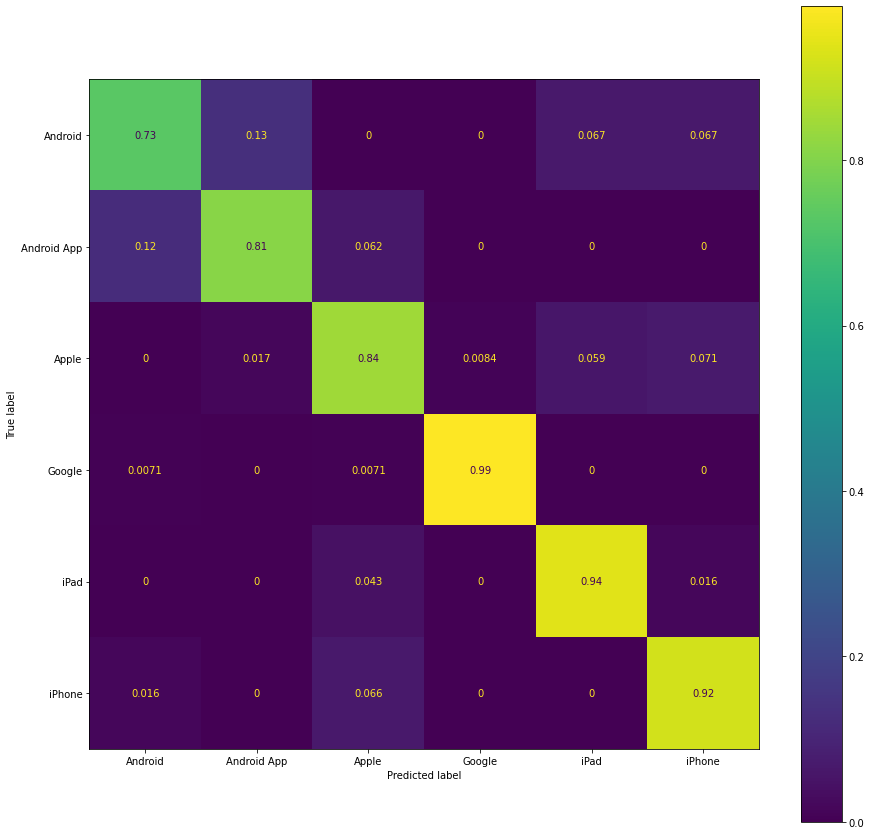

In [660]:
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(15,15))
plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax)

In [661]:
product_df['clean_text'] = product_df['text'].apply(lambda x: ' '.join(clean_text(x)))

In [662]:
product_df

,text,product,target,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,iphone hrs tweet dead need upgrade plugin
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know awe ipad iphone app likely appreciate free
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,wait ipad
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,hope year cra year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great fri mari mayer google tim o'reilly tech ...
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive,guy convince iphone great coverage prince
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive,quot;papyru like ipad&quot nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Google,Negative,diller google quot;might run play ready today....
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,Positive,camera+ iphone image mode ipad cam app feature


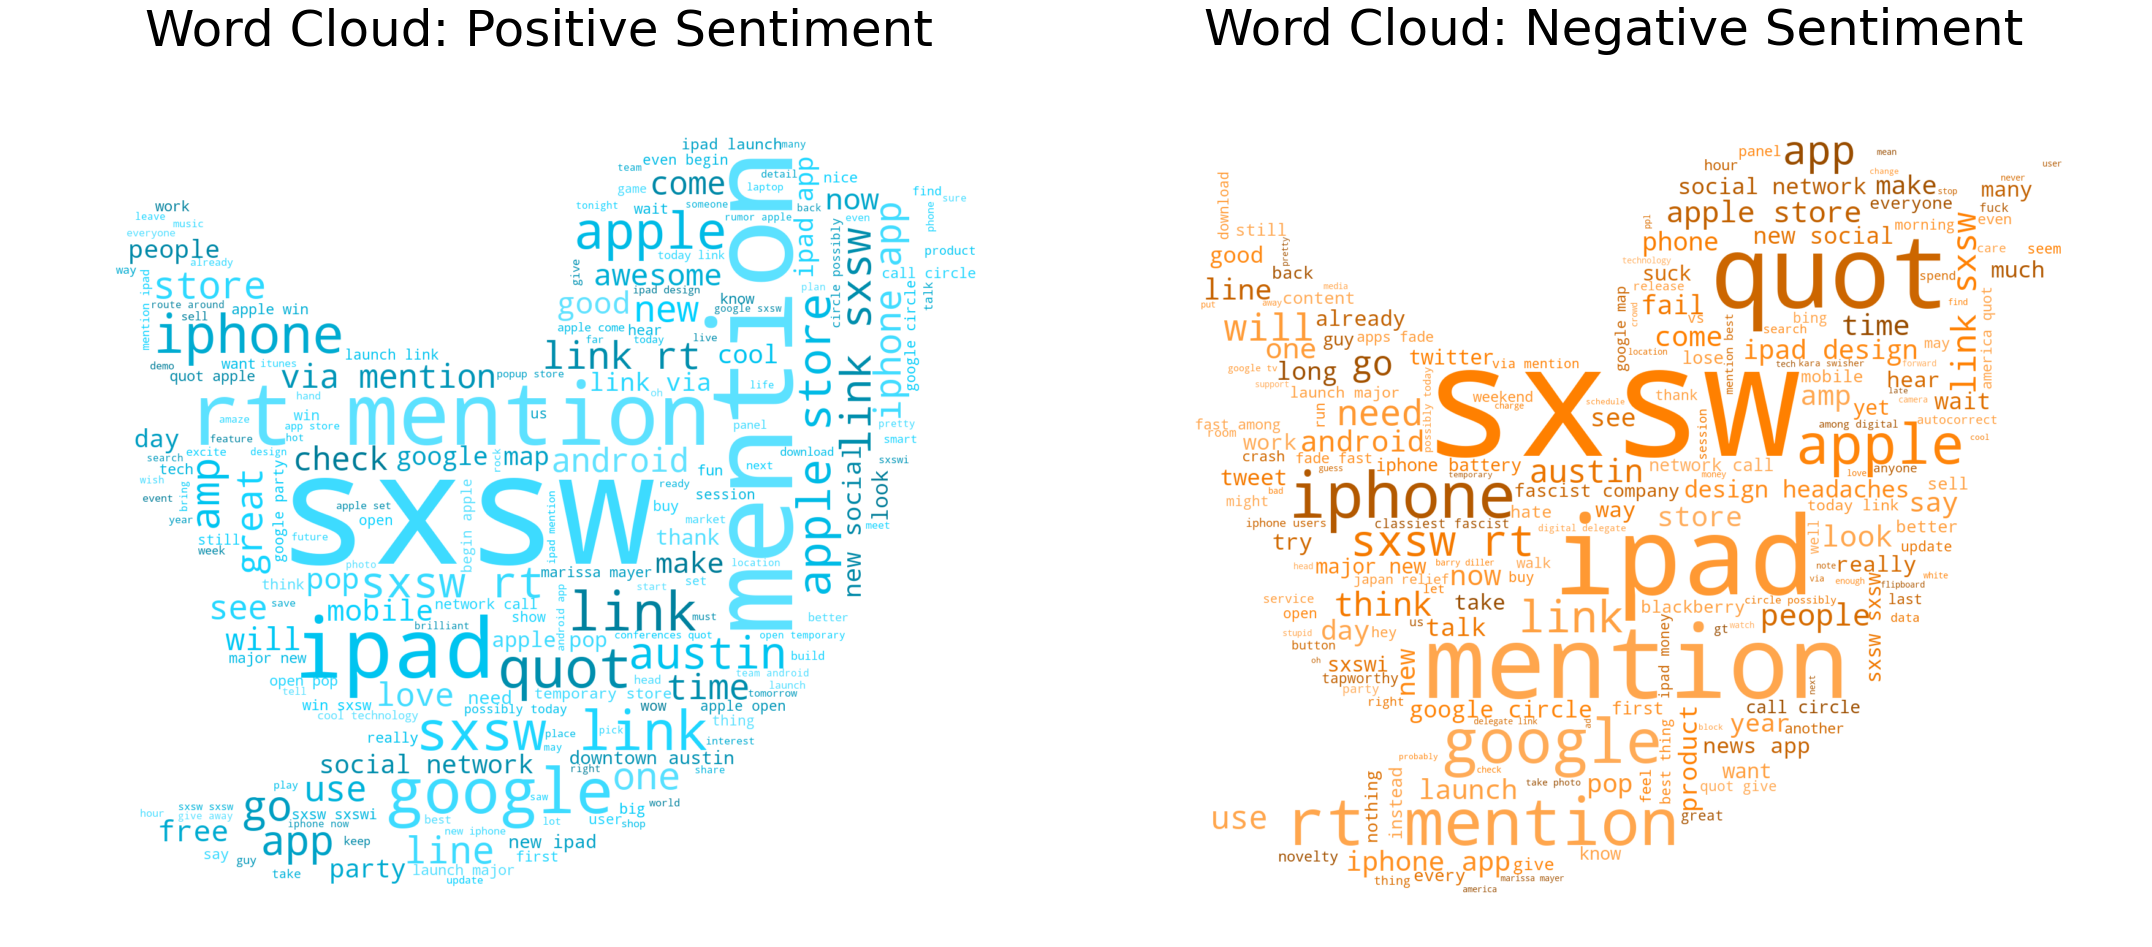

In [663]:
# wordcloud = WordCloud(collocations=False)
# wordcloud.generate(','.join(product_df[(product_df['product']=='Android')]['clean_text']))

# plt.figure(figsize=(12, 12), facecolor=None)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.title('Positive Words')

wordcloud = WordCloud(collocations=False)
wc_ = WordCloud(mask=mask, background_color="white",
               max_font_size=256,
               random_state=42, width=mask.shape[1]*1.8,
               height=mask.shape[0]*1.8, color_func=similar_color_func_blue)
wc_pos.generate(','.join(binary_df[binary_df['target']=='Positive']['clean_text']))


fig, axes = plt.subplots(ncols=2, figsize=(30,15))
axes[0].axis('off')
axes[0].imshow(wc_pos, interpolation="bilinear")
axes[0].set_title('Word Cloud: Positive Sentiment', fontdict={'fontsize': 50, 'fontweight': 'medium'})

axes[1].axis('off')
axes[1].imshow(wc_neg, interpolation="bilinear")
axes[1].set_title('Word Cloud: Negative Sentiment', fontdict={'fontsize': 50, 'fontweight': 'medium'})

plt.tight_layout()

Text(0.5, 1.0, 'Positive Words')

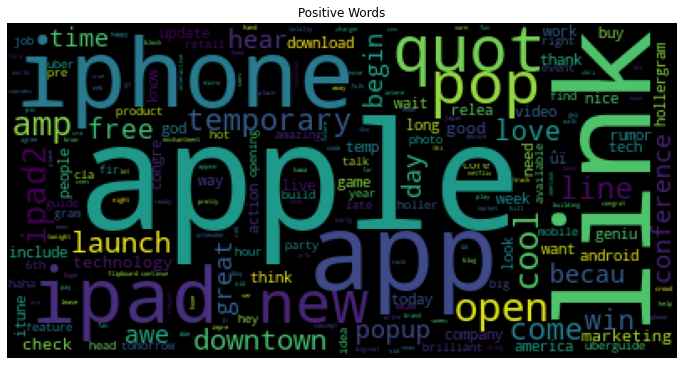

In [664]:
wordcloud = WordCloud(collocations=False)
wordcloud.generate(','.join(product_df[(product_df['product']=='Apple')]['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')

Text(0.5, 1.0, 'Positive Words')

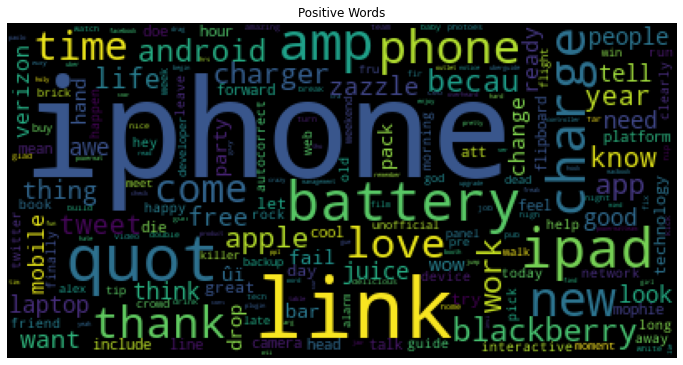

In [665]:
wordcloud = WordCloud(collocations=False)
wordcloud.generate(','.join(product_df[(product_df['product']=='iPhone')]['clean_text']))

plt.figure(figsize=(12, 12), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Positive Words')